We will attempt to generate new sequences with a seed series 
!["Sample RNN Data"](./rnn_time_1.png)
!["Sample RNN Data"](./rnn_time_2.png)
!["Sample RNN Data"](./rnn_time_3.png)
!["Sample RNN Data"](./rnn_time_4.png)
!["Sample RNN Data"](./rnn_time_5.png)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/home/jackalhan/Development/github/more_meaningful_representations/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TimeSeriesData():
    def __init__(self, num_points, x_min, x_max):
        self.x_min = x_min
        self.x_max = x_max
        self.num_points = num_points
        self.resolution = (x_max - x_min) / num_points
        self.X = np.linspace(x_min, x_max, num_points)
        self.y = np.sin(self.X)
    def next_batch(self, batch_size, steps, return_batches_timeseries=False):
        # Grab a random starting point for each batch of data
        random_start = np.random.rand(batch_size,1)
        
        # Convert to be on time series at somewhere
        ts_start = random_start * (self.x_max - self.x_min - (steps * self.resolution))
        
        # Create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
                                   
        # Create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
                                   
        # Formatting for RNN
        if return_batches_timeseries:
            # y_batch[:,:-1].reshape(-1, steps,1) : TIME SERIES
            # y_batch[:,1:].reshape(-1, steps,1) : TIME SERIES SHIFTED OVER BY ONE STEP
            return y_batch[:,:-1].reshape(-1, steps,1), y_batch[:,1:].reshape(-1, steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1, steps,1), y_batch[:,1:].reshape(-1, steps,1)
                                   

In [3]:
ts_data = TimeSeriesData(250, 0,10)

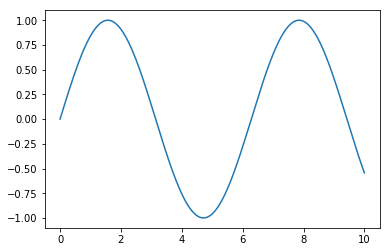

In [4]:
# Original created sin data
plt.plot(ts_data.X, ts_data.y, label = 'Sin(t)')

In [5]:
num_time_steps = 30

In [6]:
#randomly choosen points from the ts_data.X and ts_data.Y (from my sin values)
y1, y2, ts = ts_data.next_batch(1, num_time_steps, True)

In [7]:
ts.flatten().shape

(31,)

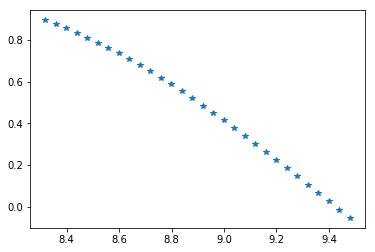

In [8]:
#ts has 31 values, 
#y2 has 30 values
# since y2 show the future, we want to start the ts from the 1. shifted one
# by typing [1:]
plt.plot(ts.flatten()[1:], y2.flatten(), '*')

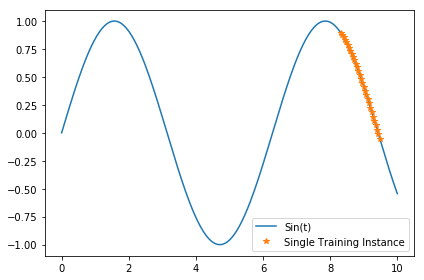

In [9]:
# Let us combine data into one plot
plt.plot(ts_data.X, ts_data.y, label = 'Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Single Training Instance')
plt.legend()
plt.tight_layout() # for prevent label blocking the line

In [10]:
# TRAINING DATA

In [11]:
train_instance = np.linspace(5, 5 + ts_data.resolution * (num_time_steps), num_time_steps + 1)

In [12]:
train_instance

array([5.  , 5.04, 5.08, 5.12, 5.16, 5.2 , 5.24, 5.28, 5.32, 5.36, 5.4 ,
       5.44, 5.48, 5.52, 5.56, 5.6 , 5.64, 5.68, 5.72, 5.76, 5.8 , 5.84,
       5.88, 5.92, 5.96, 6.  , 6.04, 6.08, 6.12, 6.16, 6.2 ])

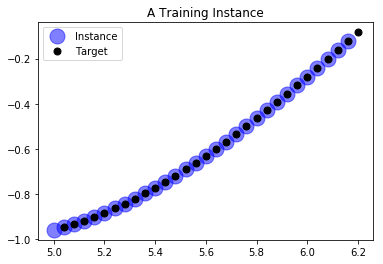

In [13]:
plt.title('A Training Instance')

#What is going to be trained, we are going to give the blue points
plt.plot(train_instance[:-1], 
         np.sin(train_instance[:-1]), 
         'bo',
         markersize=15, 
         alpha=0.5, 
         label='Instance')

#What is going to be trained, can model predict the black points?
plt.plot(train_instance[1:], 
         np.sin(train_instance[1:]), 
         'ko',
         markersize=7, 
         label='Target')

plt.legend()

### Creating the Model

In [14]:
# just to clean the tf kernel
tf.reset_default_graph()

In [15]:
num_of_inputs = 1 # one feature in this time series, value of x

In [16]:
num_of_neurons = 200 #units

In [17]:
num_of_outputs = 1 # y

In [18]:
learning_rate = 0.001

In [19]:
num_of_train_iterations = 5000

In [20]:
batch_size = 1

In [21]:
# PLACEHOLERS

In [22]:
# do not forget, None is representing the batch size
# num_time_steps was 30
X = tf.placeholder(tf.float32, [None, num_time_steps, num_of_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_of_outputs])

In [23]:
#Very Basic RNN Cell

In [24]:
cell = tf.contrib.rnn.GRUCell(num_units=num_of_neurons, activation=tf.nn.relu)
# we are just predicting one output here, we just want one time series output
# number of neurons we are using here is 100, so we do not want 100 outputs
# we need to project this kust to be one, the way we can do is using output projection wrapper
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_of_outputs)

In [25]:
# now we want to get the outputs and the states of these basic RNN cells
# the way, we can do that is using dynamic RNN. 
# dynamic_rnn just creates a RNN specified by the actuall cell that we just created
# it is going to automatically ouput both the outputs and the states of this cells
# it performs a dynamic unrolling of the inputs that basically just means
# it is using a while loop operation to run over the cell the approp. number of times.
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32)

In [26]:
# LOSS function, mse
loss = tf.reduce_mean(tf.square(outputs - y))

In [27]:
# OPTIMIZER
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [28]:
# SESSION
init = tf.global_variables_initializer()
# in order not to crash GPU, we want to use some part of the GPU memory instead of all of them.
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)
# saver function to save our model 
saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    for i in range(num_of_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X:X_batch, y:y_batch})
        if i % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(i, "\tMSE", mse)
    
    saver.save(sess, "./models/my_own_rnn_time_series_model")

0 	MSE 0.36724505
100 	MSE 0.042020995
200 	MSE 0.019498266
300 	MSE 0.0018920373
400 	MSE 0.0106382845
500 	MSE 0.0033768394
600 	MSE 0.002648171
700 	MSE 0.0014375743
800 	MSE 0.004009652
900 	MSE 0.0017334764
1000 	MSE 8.4389474e-05
1100 	MSE 0.0007540317
1200 	MSE 0.00053703383
1300 	MSE 1.8235816e-05
1400 	MSE 0.00026315782
1500 	MSE 9.678792e-05
1600 	MSE 0.00012920586
1700 	MSE 4.2602678e-05
1800 	MSE 2.241786e-05
1900 	MSE 5.1841744e-05
2000 	MSE 0.00022564866
2100 	MSE 9.279641e-05
2200 	MSE 1.5744481e-05
2300 	MSE 8.8552624e-05
2400 	MSE 5.656863e-05
2500 	MSE 2.2623957e-05
2600 	MSE 8.136469e-05
2700 	MSE 2.462404e-05
2800 	MSE 1.4234288e-05
2900 	MSE 4.5317764e-05
3000 	MSE 0.00018397406
3100 	MSE 4.0157076e-05
3200 	MSE 7.985705e-05
3300 	MSE 5.94755e-05
3400 	MSE 2.971349e-05
3500 	MSE 6.951959e-05
3600 	MSE 2.6353413e-05
3700 	MSE 0.00020035078
3800 	MSE 0.00028367862
3900 	MSE 4.5667e-05
4000 	MSE 4.210251e-05
4100 	MSE 0.0003068769
4200 	MSE 6.0795843e-05
4300 	MSE 7.0

In [29]:
# Now attempt to predict the time series or one step into the future
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    saver.restore(sess, "./models/my_own_rnn_time_series_model")
    X_new = np.sin(np.array(train_instance[:-1].reshape(-1, num_time_steps, num_of_inputs)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./models/my_own_rnn_time_series_model


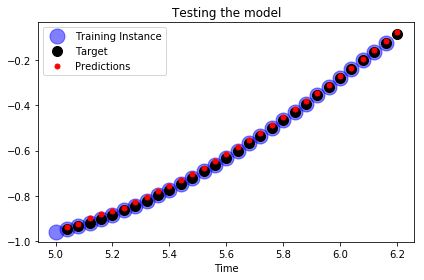

In [30]:
plt.title("Testing the model")
# Training Instance
plt.plot(train_instance[:-1], np.sin(train_instance[:-1]), "bo", markersize=15, alpha=0.5, label='Training Instance')
# Target to Predict(Correct Test Values np.sin(TRAIN DATA))
plt.plot(train_instance[1:], np.sin(train_instance[1:]), "ko", markersize=10, label='Target')
# Models Prediction
plt.plot(train_instance[1:], y_pred[0,:,0], 'r.', markersize=10, label='Predictions')

plt.xlabel('Time')
plt.legend()
plt.tight_layout()

# We can play with options like BasicLSTMCell. MultiRNNCell and so on.

### GENERATING NEW SEQUENCE

In [31]:
# WE previously created a time series sequence that shifted just one time step over
with tf.Session() as sess:
    saver.restore(sess, "./models/my_own_rnn_time_series_model")
    
    # SEED ZEROES
    # Burada yaptigimiz sey, egitilmis moele oyle bir veri veriyoruz ki, bu veriler 0 oluyor
    # ve bu modelin 0 verilerini kullanarak, 30 luk timesteplerini nasil uretebildigine bakiyoruz. 
    # yani her 0 a karsin 30 luk dilimde neler uretiyor ve en son tahmin edilen ilk iteration a karsi
    # predict edilen y degeri oluyor o nedenle y_pred[0,-1,0] aliniyor.  
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    for iteration in range(len(ts_data.X) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps,1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        # I am trying to get the 30 zeros and then generated values
        # always get the value from the last item of y predictions
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./models/my_own_rnn_time_series_model


Text(0,0.5,'Y')

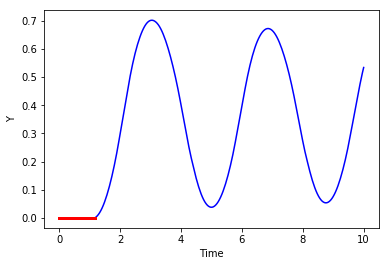

In [32]:
# Verilen deger inputlar yani 0 lar kirmizi olarak gosteriliyor. 
plt.plot(ts_data.X, zero_seq_seed, 'b-')
plt.plot(ts_data.X[:num_time_steps], zero_seq_seed[:num_time_steps], 'r', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Y')

In [33]:
# simdi 0 ile baslatmak yerine, daha mantikli sayilarla baslatalim, yani biraz gercekci sin 
# degerleri ile baslatalim bakalim model nasil uretecek

# WE previously created a time series sequence that shifted just one time step over
with tf.Session() as sess:
    saver.restore(sess, "./models/my_own_rnn_time_series_model")
    
    # SEED ZEROES
    # Burada yaptigimiz sey, egitilmis moele oyle bir veri veriyoruz ki, bu veriler gercek sin oluyor
    # ve bu modelin o verilerini kullanarak, 30 luk timesteplerini nasil uretebildigine bakiyoruz. 
    # yani her sin a karsin 30 luk dilimde neler uretiyor ve en son tahmin edilen ilk iteration a karsi
    # predict edilen y degeri oluyor o nedenle y_pred[0,-1,0] aliniyor.  
    taraining_instance = list(ts_data.y[:num_time_steps])
    for iteration in range(len(ts_data.X) - num_time_steps):
        X_batch = np.array(taraining_instance[-num_time_steps:]).reshape(1, num_time_steps,1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        
        # I am trying to get the 30 zeros and then generated values
        # always get the value from the last item of y predictions
        taraining_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./models/my_own_rnn_time_series_model


Text(0,0.5,'Y')

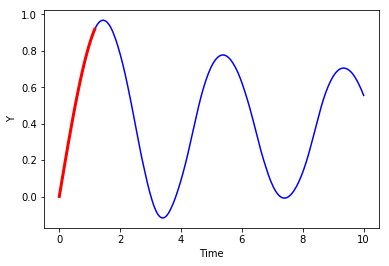

In [34]:
# Verilen deger inputlar yani 0 lar kirmizi olarak gosteriliyor. 
plt.plot(ts_data.X, taraining_instance, 'b-')
plt.plot(ts_data.X[:num_time_steps], taraining_instance[:num_time_steps], 'r-', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Y')

In [ ]:
# Simdi gercege cok bzenyior